In [1]:
import os
from glob import glob

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
from numpy import eye, dot

In [3]:
from scipy.linalg import expm, inv

In [28]:
import cv2 as cv
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt

In [29]:
from IPython.display import YouTubeVideo

In [30]:
from tpk4170.hand_eye_calibration import chessboard, park_martin
from tpk4170.hand_eye_calibration.utils import load_images, load_rob_poses

# Eye-to-hand Calibration

![](https://www.torsteinmyhre.name/snippets/robcam_calibration/images/extrinsic-camera-calibration-stationary-camera-651px.png)

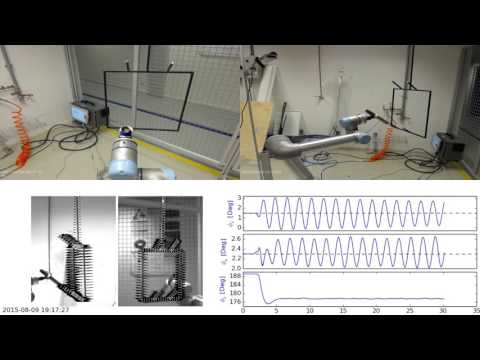

In [31]:
YouTubeVideo('0EAKonCFusg', width=560, height=315)

## Load images and poses

In [32]:
images = load_images()

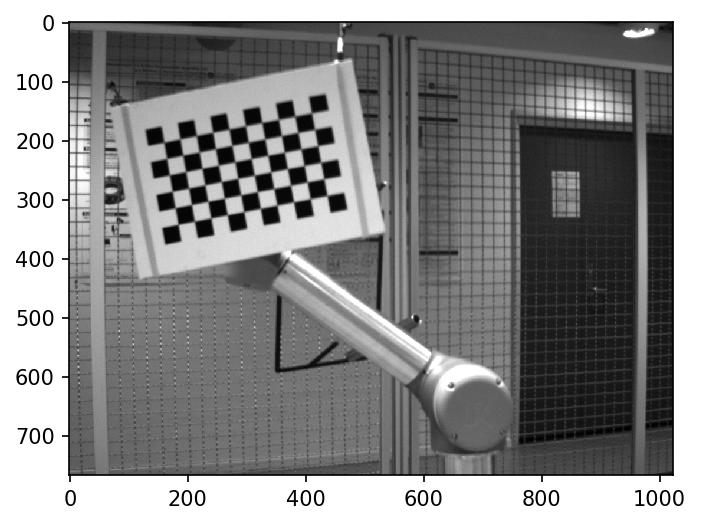

In [35]:
plt.imshow(images[6], cmap=plt.cm.get_cmap('gray'));

In [36]:
rob_poses = load_rob_poses()
print(rob_poses[6])

[[-0.06655535 -0.75312054 -0.6545074  -0.37372711]
 [ 0.09438381  0.64826852 -0.75553936  0.02285725]
 [ 0.99330866 -0.11206008  0.02793666  0.83707798]
 [ 0.          0.          0.          1.        ]]


## Calibrate intrinsic camera parameters

In [37]:
camera_matrix, dist_coeffs = chessboard.calibrate_lens(images)
print(camera_matrix)

[[1332.01106779    0.          525.77233463]
 [   0.         1332.79039342  368.45965855]
 [   0.            0.            1.        ]]


In [38]:
print(dist_coeffs)

[-0.29976699  0.97205715 -0.00166564 -0.00050881 -2.10672354]


## Estimate the pose of each chessboard in the camera frame

In [39]:
def hat(v):
    return [[0, -v[2],  v[1]],
            [v[2],     0, -v[0]],
            [-v[1],  v[0],    0]]

In [40]:
def tf_mat(r, t):
    res = eye(4)
    res[0:3, 0:3] = expm(hat(r))
    res[0:3, -1] = t
    return res

In [41]:
obj_poses = []
corner_list = []
for i, img in enumerate(images):
    found, corners = chessboard.find_corners(img)
    corner_list.append(corners)
    if not found:
        raise Exception("Failed to find corners in img # %d" % i)
    rvec, tvec = chessboard.get_object_pose(
        chessboard.pattern_points, corners, camera_matrix, dist_coeffs)
    object_pose = tf_mat(rvec, tvec)
    obj_poses.append(object_pose)

## Compute motions between each pose pair

In [42]:
A, B = [], []
for i in range(1, len(images)):
    p = rob_poses[i-1], obj_poses[i-1]
    n = rob_poses[i], obj_poses[i]
    A.append(dot(inv(p[0]), n[0]))
    B.append(dot(inv(p[1]), n[1]))

## Compute the robot gripper to chessboard transform

In [43]:
# Transformation to chessboard in robot gripper
X = eye(4)
Rx, tx = park_martin.calibrate(A, B)
X[0:3, 0:3] = Rx
X[0:3, -1] = tx

print('X: ')
print(X)

X: 
[[ 0.09853313 -0.99513261  0.00151965  0.04083886]
 [-0.99510923 -0.09854131 -0.00687275  0.09969052]
 [ 0.00698905 -0.00083503 -0.99997523  0.15899348]
 [ 0.          0.          0.          1.        ]]


For validation: Printing transformations from the robot base to the camera. All the transformations should be quite similar.

In [44]:
for i in range(len(images)):
    rob = rob_poses[i]
    obj = obj_poses[i]
    tmp = dot(rob, dot(X, inv(obj)))
    print(tmp, '\n')

[[ 0.73440851  0.01537859  0.67853332 -0.99273101]
 [-0.67862591  0.00112074  0.73448326 -0.8800224 ]
 [ 0.01053486 -0.99988113  0.01125937  0.74050302]
 [ 0.          0.          0.          1.        ]] 

[[ 0.73262243  0.01627859  0.68044066 -0.99479051]
 [-0.6805475   0.00146293  0.7327025  -0.87803725]
 [ 0.01093194 -0.99986641  0.01215011  0.73824691]
 [ 0.          0.          0.          1.        ]] 

[[ 0.73879692  0.01895382  0.67366148 -0.985715  ]
 [-0.67360731 -0.01006586  0.73902083 -0.87817649]
 [ 0.02078827 -0.99976965  0.0053308   0.75086777]
 [ 0.          0.          0.          1.        ]] 

[[ 0.73959807  0.01997899  0.6727522  -0.98471032]
 [-0.67270204 -0.01013806  0.73984397 -0.87887138]
 [ 0.02160177 -0.99974908  0.00594186  0.75148219]
 [ 0.          0.          0.          1.        ]] 

[[ 0.74415318  0.01941701  0.66772666 -0.97820253]
 [-0.66766939 -0.0102472   0.74438734 -0.8829052 ]
 [ 0.02129617 -0.99975899  0.00533867  0.75861432]
 [ 0.          0.  

In [47]:
# Here we just pick one, but an average can be used instead
rob = rob_poses[0]
obj = obj_poses[0]
cam_pose = dot(dot(rob, X), inv(obj))

In [48]:
print(cam_pose)

[[ 0.73440851  0.01537859  0.67853332 -0.99273101]
 [-0.67862591  0.00112074  0.73448326 -0.8800224 ]
 [ 0.01053486 -0.99988113  0.01125937  0.74050302]
 [ 0.          0.          0.          1.        ]]
